# INDIVIDUAL PLANNING STAGE:

The dataset players.csv consists of the name, Age, and gender of the player, whether or not theyre subscribed, their hashedEmail, their experience, and the number of hours they played (played_hours). 
- It has 196 different players recorded.

The dataset sessions.csv consists of each session every student played, so it has the hashed email, the start and end time of their session in a proper date/time format, and the Epoch unix time stamp in the form of 1.XXXXXE+12, which is the number of seconds from January 1, 1970. 
- After looking at the data, it has 1535 different sessions

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("players.csv")
players
sessions <- read_csv("sessions.csv")
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


A question that seems interesting to answer is to see what player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? More specifically, if **hours played** affects if they subscribe, and if it changes depending on their **gender**. Therefore, we won't be using the sessions.csv file.

So, i'll most likely have to do a histogram, where the x axis is the played hours, and the y axis could be the proportion of players that subscribe? we can play around with that later. and then we can maybe do a bar graph with each bar being a different gender, and the y axis being the count of people that subscribe. An issue with this, however, is that there are much more Male and Female players than any other gender, so we might have to also keep this a proportion.

Warning message:
“Removed 74 rows containing missing values or values outside the scale range
(`geom_bar()`).”


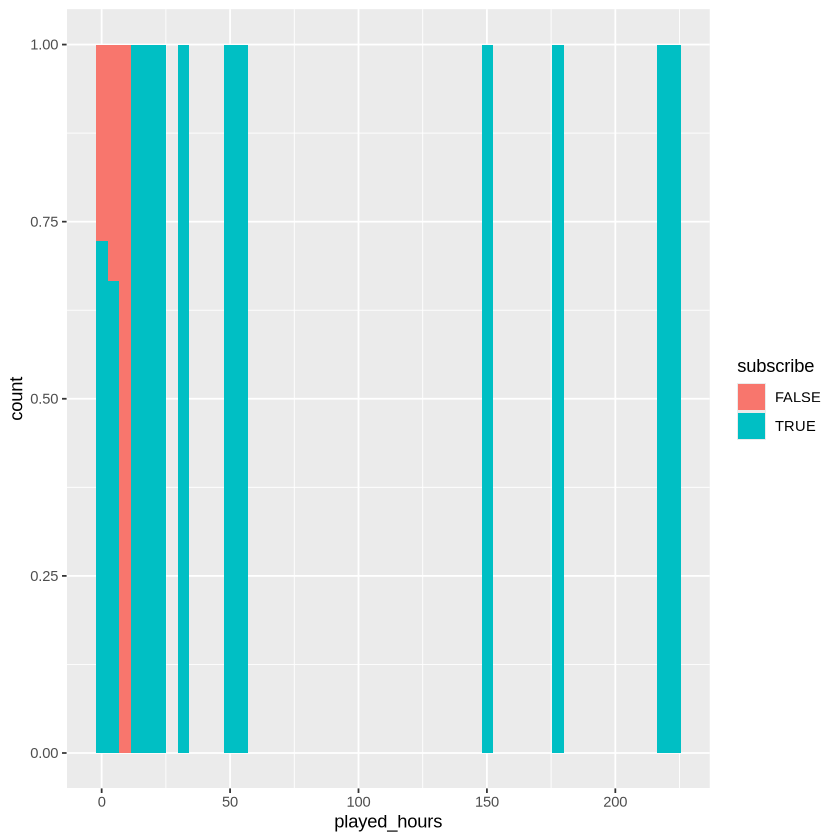

In [3]:
graph_hours <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(position = "fill", bins = 50)
graph_hours

The data for played_hours is very spread out, so between 50 and 150, there are barely any players. we're gonna have to scale the x axis logarithmically. we'll also choose more approriate names for the x and y axis, and the fill name.

Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_bar()`).”


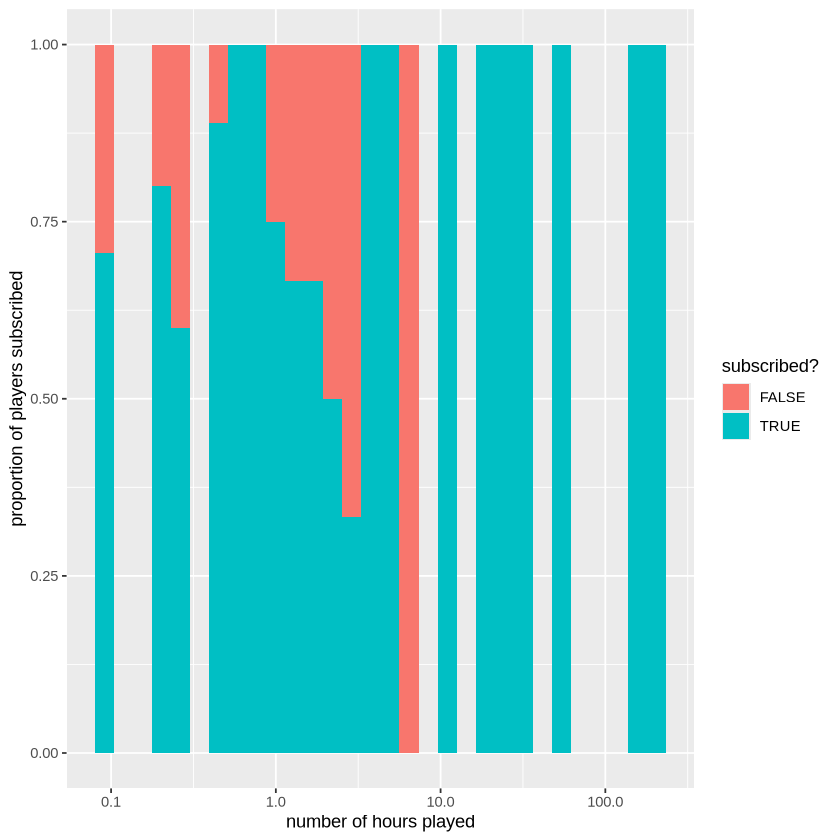

In [4]:
scaled_graph_hours <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(position = "fill", bins = 30) +
        labs(x = "number of hours played", y = "proportion of players subscribed", fill = "subscribed?") +
        scale_x_log10(labels = label_comma()) 
scaled_graph_hours

although its a bit hard to read, we can clearly see that every player that has 10 or more hours played is subscribed. However, weirdly enough, between 0:10, it seems like the proportional of people subscribed falls more and more as we get closer to 10. Now firstly, lets see how many people have more than 10 hours played as it could just be a small number.

In [5]:
players_more_than_10 <- players |>
    filter(played_hours >=10) |>
    count()
players_more_than_10

n
<int>
13


There are only 13 students with 10 or more hours, this is only 13/196, or 6.6% of the players. Therefore, its not conclusive enough to answer our question. We can remove position = "fill" to see the number.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


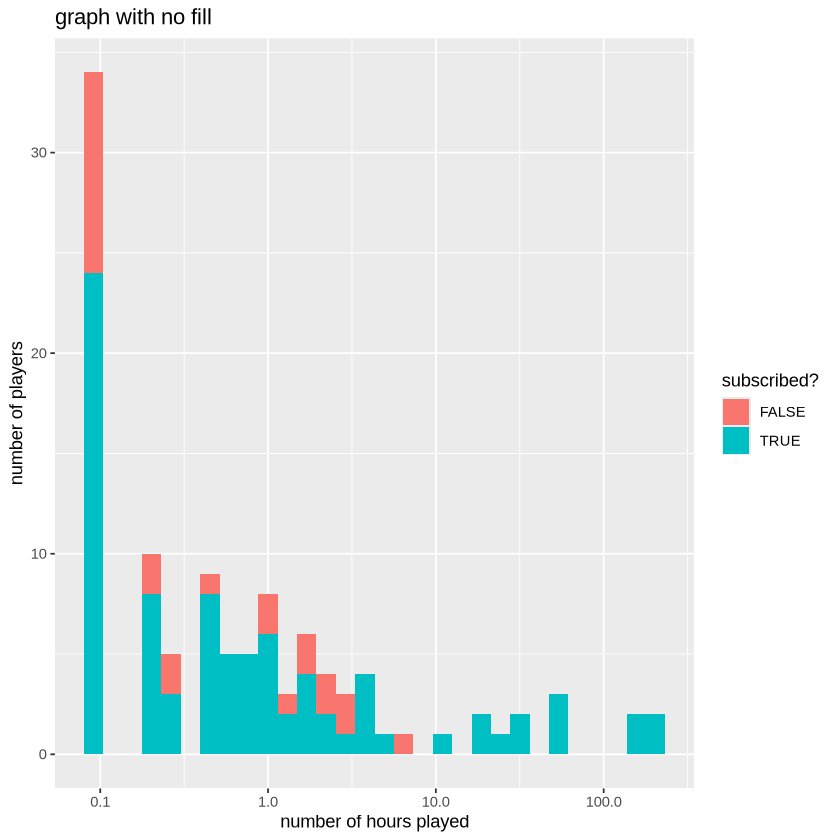

In [6]:
no_fill_graph_hours <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(bins = 30) +
        labs(x = "number of hours played", y = "number of players", fill = "subscribed?") +
        scale_x_log10() +
        ggtitle("graph with no fill")
no_fill_graph_hours

we see that a much larger portion of players have < 10 hours played, and 

Warning message:
“Removed 26 rows containing missing values or values outside the scale range
(`geom_bar()`).”


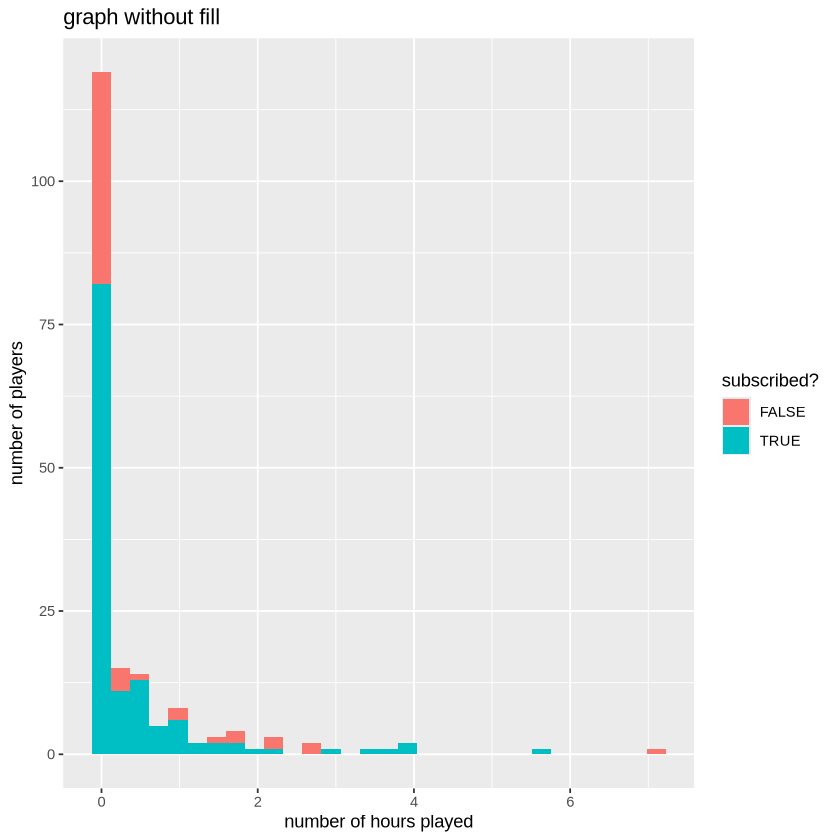

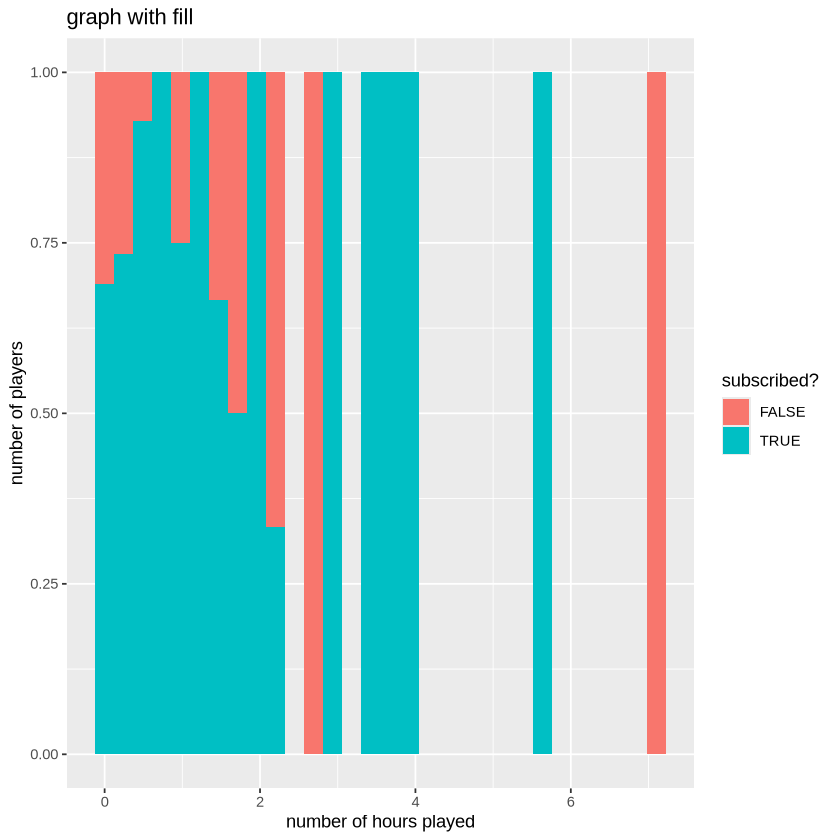

In [7]:
filtered_graph_hours <- players |>
    filter(played_hours < 10) |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(bins = 30) +
        labs(x = "number of hours played", y = "number of players", fill = "subscribed?") +
        ggtitle("graph without fill")
filtered_graph_hours

filtered_graph_hours <- players |>
    filter(played_hours < 10) |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(position = "fill", bins = 30) +
        labs(x = "number of hours played", y = "number of players", fill = "subscribed?") +
        ggtitle("graph with fill")
filtered_graph_hours

theres a huge proportion of players who seem to have played 0 hours

In [17]:
players_with_0 <- players |>
    filter(played_hours == 0) |>
    count()
players_with_0

players_with_less_than_0.3 <- players |>
    filter(played_hours < 0.3) |>
    count()
players_with_less_than_0.3

n
<int>
85


n
<int>
129


this is quite a big issue, 129/196, or 66% of the players have barely even played the game. 0.2 hours is 12 minutes. (played_hours is in steps of 0.1, so < 0.3 is the same as <= 0.2).

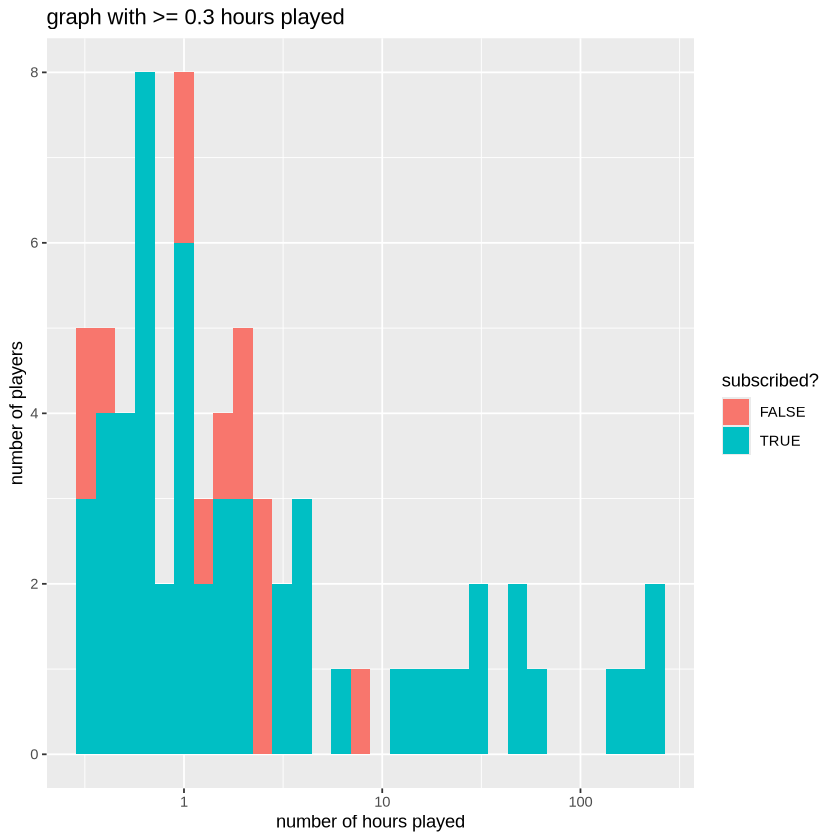

In [20]:
no_0_graph_hours <- players |>
    filter(played_hours > 0.2) |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(bins = 30) +
        labs(x = "number of hours played", y = "number of players", fill = "subscribed?") +
        ggtitle("graph with >= 0.3 hours played") +
        scale_x_log10()
no_0_graph_hours

And looking at this data, it honestly just doesnt have much of a pattern, however, we can only decide after building a model.

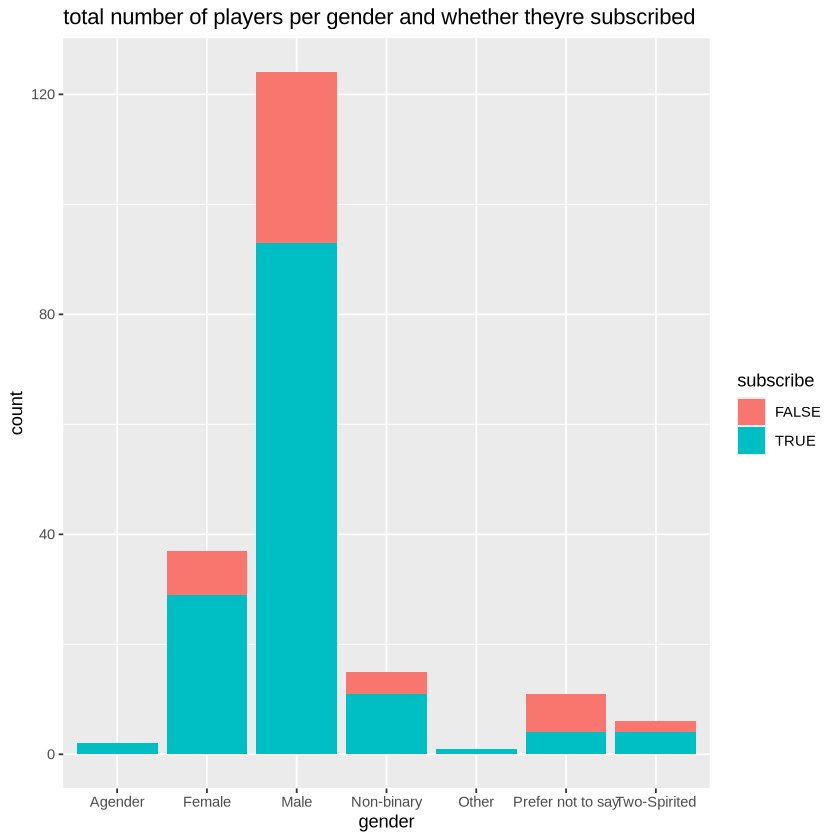

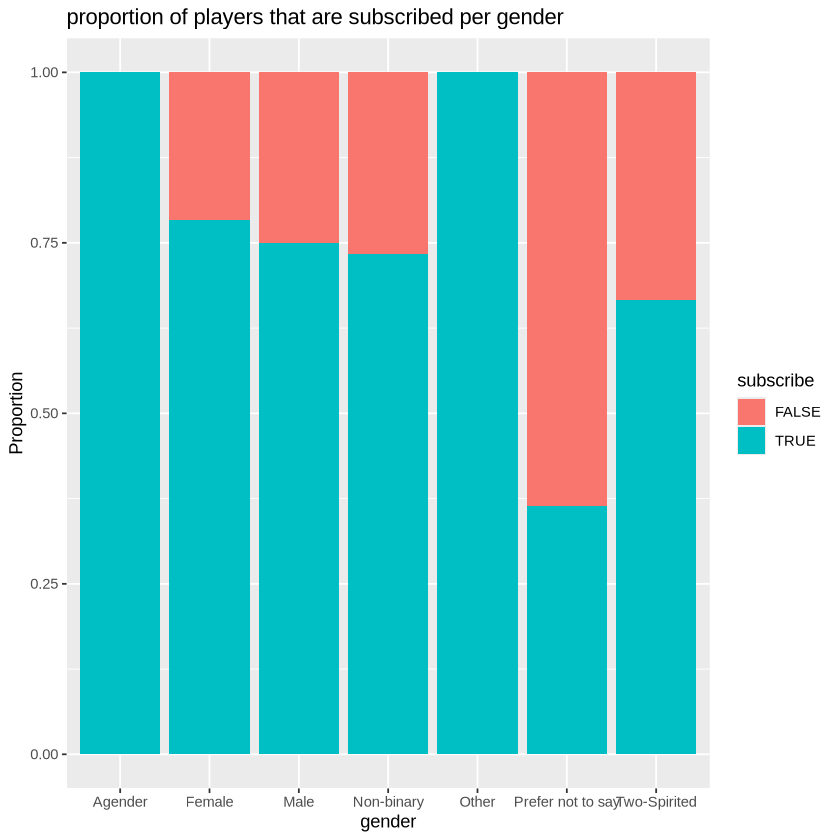

In [33]:
gender_graph <- players |>
    ggplot(aes(x = gender, fill = subscribe)) +
        geom_bar(stat = "count") +
        ggtitle("total number of players per gender and whether theyre subscribed")
gender_graph

gender_graph <- players |>
    ggplot(aes(x = gender, fill = subscribe)) +
        geom_bar(position = "fill") +
        ggtitle("proportion of players that are subscribed per gender") +
        labs(y = "Proportion")
gender_graph

We can see that Agender and Other are more likely to subscribe, while Prefer not to say is less likely to subscribe. and male, female, and non-binary have a 75% chance of subscribing. 